# Read IVUS images

In [1]:
import SimpleITK as sitk
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
from math import sqrt
from tqdm import tqdm

import pickle
import pandas as pd
import time
import os
from feature_utils import *

In [2]:
def im2arr(x):
    return sitk.GetArrayFromImage(sitk.ReadImage(x))


In [3]:
datadir= "data"
files = sorted(glob.glob(datadir+"/*.mha"))

In [4]:
im = im2arr(files[0])  #im becomes a numpy array
im.shape

(2381, 256, 256)

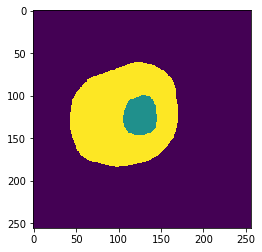

In [5]:
plt.imshow(im[2380])

In [6]:
def sample_stack(stack, rows=5, cols=5, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind])
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

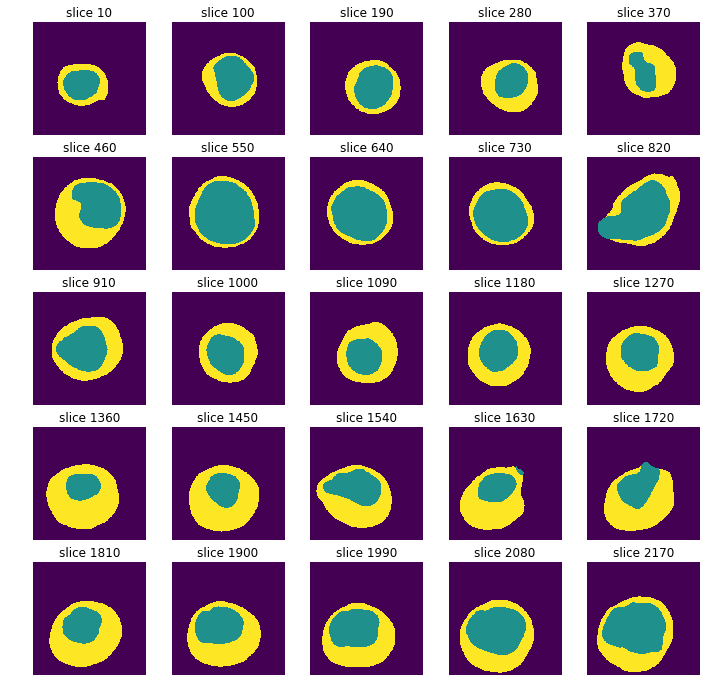

In [7]:
imstack = im2arr(files[0])
sample_stack(imstack, show_every=90)

# Ecentricity

In [8]:
im.shape

(2381, 256, 256)

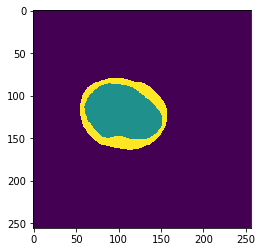

In [9]:
frame = im[0]
plt.imshow(frame)

In [10]:
unique, counts = np.unique(frame, return_counts=True)
>>> dict(zip(unique, counts))

{0: 58690, 1: 4517, 2: 2329}

In [11]:
frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
ret, thresh = cv2.threshold(frame8, 129, 255, 0)
frame8.dtype

dtype('uint8')

In [12]:
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
#frame8rgb = cv2.convertScaleAbs(framergb)


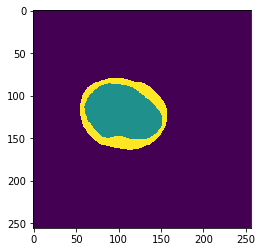

In [13]:
plt.imshow(frame8)

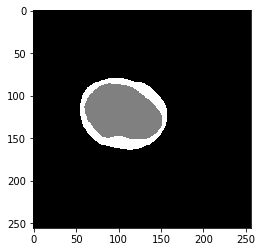

In [14]:
plt.imshow(framergb)

In [15]:
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

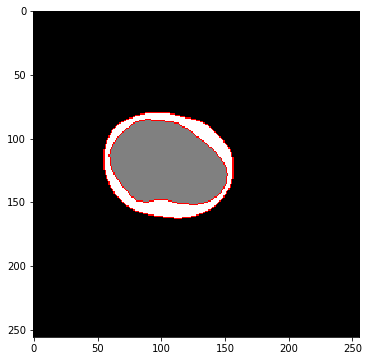

In [16]:
im2 = framergb.copy()
cv2.drawContours(im2, contours, -1, (255,0,0), 1)
plt.figure(figsize=[6,6])
plt.imshow(im2)

In [17]:
parent = [ x[-1] for x in hierarchy[0] ]
index = np.where(np.array(parent) == 0)[0][0]
lumen_c = contours[index]

In [18]:
M = cv2.moments(lumen_c)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

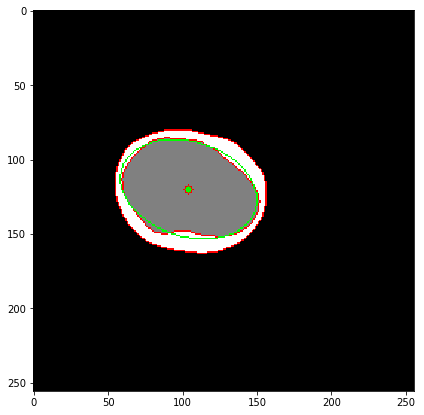

In [21]:
im3 = im2.copy()
cv2.drawContours(im3, lumen_c, -1, (255,0,0), 1)
cv2.circle(im3, (cX, cY), 3, (255,0,0), -1)
(x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
ellipse = cv2.fitEllipse(lumen_c)
cv2.ellipse(im3,ellipse,(0,255,0),1)
cv2.circle(im3, (round(x),round(y)), 2, (0,255,0), -1)
plt.figure(figsize=[7,7])
plt.imshow(im3)

In [22]:
print(minaxis,maxaxis)

63.70004653930664 93.93872833251953


# Find the intersection between line and contour

In [23]:
frame.shape

(256, 256)

In [24]:
points = np.array([lumen_c[0][0],[cX,cY]])
print(points)

[[ 87  86]
 [104 120]]


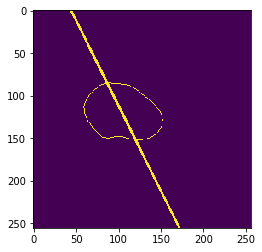

In [26]:
#draw contour 
img3 = np.zeros((256,256,3), np.uint8)
cv2.drawContours(img3, lumen_c, -1, (255,255,255), 1)
img4 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
img5 = np.zeros((256,256), np.uint8)
[vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,0,0.01,0.01)
l = 300
cv2.line(img5, (x-(vx*l), y-(vy*l)), (x+(vx*l), y+(vy*l)), (255,0,0),2)
plt.imshow(img5 | img4 )

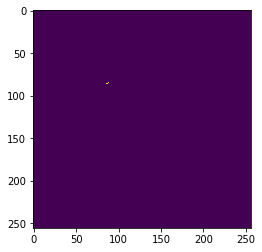

In [27]:
imgcombo = cv2.bitwise_and(img4,img5)
intersect = np.argwhere(imgcombo == 255)
x1 = intersect[0][0]
y1 = intersect[0][1]
x2 = intersect[-1][1]
y2 = intersect[-1][0]

plt.imshow(imgcombo)

85 88 121 151


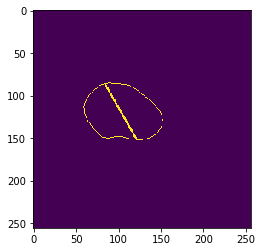

In [28]:
img6 = np.zeros((256,256), np.uint8)
cv2.line(img6, (x1, y1), (x2, y2), (255,0,0),2)
plt.imshow(img6 | img4)
print(x1,y1,x2,y2)

In [29]:
sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

72.56031973468694

# The Script

In [30]:
## the eccentricity script
from tqdm import tqdm

def im2arr(x):
    return sitk.GetArrayFromImage(sitk.ReadImage(x))

def picklereader(fpath):
    with open(fpath,'rb') as f:
        content = pd.read_pickle(f)
    return content

def diameter_lumen(mha,region):
    '''
    mha: mha file - the image stack for a record
    region: list of frames for the region of interest
    returns list of lumen diameters
    '''
    imstack = im2arr(mha)   #read image stack
    diameters = []
    for im in tqdm(imstack[region[0]:region[1]]):
        #loop through half of the points on the lumen contour and measure diameters
        frame8 = cv2.convertScaleAbs(im,alpha=(255.0/2.0))   #upscale pixel range to 255
        framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)   #create rgb version of image
        ret, thresh = cv2.threshold(frame8, 129, 255, 0)   #create threshold image
        _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)   #find contours for both plaque and lumen
        parent = [ x[-1] for x in hierarchy[0] ]    #get contour hierarchies
        if any(np.array(parent) == 0):
            # only find distance if lumen contour (child) exists
            index = np.where(np.array(parent) == 0)[0][0]   #find child contour (lumen)
            lumen_c = contours[index]   #get lumen contour
            M = cv2.moments(lumen_c)   #get center lumen
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            lumen_diam = []
            for c in range(0,round(len(lumen_c)/2),2):   #skip every other point on contour speeds up extract
                point = lumen_c[c][0].tolist()
                x0 = point[0]
                y0 = point[1]
                vx = x0-cX
                vy = y0-cY

                #draw line through contour center
                img5 = np.zeros((256,256), np.uint8)   
                l = 300
                cv2.line(img5, (cX-(vx*l), cY-(vy*l)), (cX+(vx*l), cY+(vy*l)), (255,0,0),2)

                #draw contour 
                img3 = np.zeros((256,256,3), np.uint8)
                cv2.drawContours(img3, lumen_c, -1, (255,255,255), 1)
                img4 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

                #find intersection of line and contour
                imgcombo = cv2.bitwise_and(img4,img5)
                intersect = np.argwhere(imgcombo == 255)
                x1 = intersect[0][0]
                y1 = intersect[0][1]
                x2 = intersect[-1][1]
                y2 = intersect[-1][0]

                distance = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
                lumen_diam.append(distance)
            diameters.append([min(lumen_diam),max(lumen_diam)])
        else: 
            continue   #??? What to do when there is no child contour or something is wrong
                       #with the image file. I'd like to move to the next element in the list
    d_min = [item[0] for item in diameters]
    d_max = [item[1] for item in diameters]
    return np.mean(np.sqrt(np.power(d_max,2) - np.power(d_min,2)/np.array(d_max)))

def ecc_lumen_worst(pid,luAc,distal,os,files):
    '''
    pid: unique identifier
    luAc: lumen area
    distal: roi distal
    os: roi ostium
    files: directory with .mha files
    '''
    print(pid)
    if any(pid in item for item in files):
        region = list(worst5mm (luAc,distal,os))
        i = [i for i, s in enumerate(files) if pid in s][0]
        print(i, pid)
        return diameter_lumen(files[i],region)


In [31]:
df = picklereader(os.getcwd()+'/data/df18S_rs_extract.p')

In [32]:
df.head()

,PID,gender,age,vessel,seg,ffr,ffr_80,n_frame,OS,distal,...,RI_MLA_ref,RI_MLA_prox5,RI_worst_ref,RI_worst_prox5,variance_lumen_worst,variance_lumen_PB40,variance_plaque_worst,variance_plaque_PB40,long_eccentricity_worst,long_eccentricity_PB40
0,F0002,1,59,1,1,0.83,0,2381,2152,91,...,0.000000,0.000000,0.000000,0.000000,0.517217,7.890320,1.187166,7.783799,0.072780,0.383794
1,F0003,2,73,1,2,0.91,0,3642,3097,551,...,0.000000,0.000000,0.000000,0.000000,0.097784,5.809565,0.050160,2.131793,0.058916,0.892380
2,F0004,1,61,1,2,0.72,1,4060,3463,261,...,0.000000,0.000000,0.000000,0.000000,1.212633,0.903290,2.197129,6.271595,0.046846,0.077764
3,F0005,1,61,3,2,0.83,0,3970,3883,285,...,0.000000,0.000000,0.000000,0.000000,0.194207,2.302834,0.036625,0.995525,0.041690,0.371873
4,F0007,1,60,1,2,0.85,0,2813,2610,465,...,1.023542,0.780071,1.047452,0.798293,2.968152,16.178021,2.637238,3.715845,0.069930,0.154312


In [34]:
files

['data/F0002_DownSampling_Mask.mha',
 'data/F0003_DownSampling_Mask.mha',
 'data/F0004_DownSampling_Mask.mha',
 'data/F0005_DownSampling_Mask.mha',
 'data/F0007_DownSampling_Mask.mha',
 'data/F0008_DownSampling_Mask.mha',
 'data/F0009_DownSampling_Mask.mha',
 'data/F0010_DownSampling_Mask.mha']

In [35]:
test = df.apply(lambda x: ecc_lumen_worst(x.PID,x.luAc,x.distal,x.OS,files),axis=1)

F0002
0 F0002


100%|██████████| 300/300 [00:16<00:00, 18.65it/s]


F0003
1 F0003


100%|██████████| 300/300 [00:08<00:00, 34.28it/s]


F0004
2 F0004


100%|██████████| 300/300 [00:09<00:00, 31.28it/s]


F0005
3 F0005


100%|██████████| 300/300 [00:08<00:00, 33.73it/s]


F0007
4 F0007


100%|██████████| 300/300 [00:12<00:00, 23.34it/s]


F0008
5 F0008


100%|██████████| 300/300 [00:10<00:00, 29.02it/s]


F0009
6 F0009


100%|██████████| 300/300 [00:11<00:00, 26.87it/s]


F0010
7 F0010


 24%|██▍       | 72/300 [00:02<00:08, 27.70it/s]


F0002
0 F0002


100%|██████████| 300/300 [00:16<00:00, 18.72it/s]


F0003
1 F0003


 46%|████▋     | 139/300 [00:03<00:04, 36.22it/s]


KeyboardInterrupt: 

In [43]:
test = df[7:8]
test.apply(lambda x: ecc_lumen_worst(x.PID,x.luAc,x.distal,x.OS,files),axis=1)

F0010
7 F0010


 24%|██▍       | 73/300 [00:01<00:06, 37.24it/s]


F0010
7 F0010


 24%|██▍       | 73/300 [00:01<00:05, 38.55it/s]


TypeError: ("'NoneType' object is not subscriptable", 'occurred at index 7')

# TEST PID = F0010 index=7

In [48]:
mha = 7
im = imstack[71]
lineindex = 8

imstack = im2arr(files[mha])
frame8 = cv2.convertScaleAbs(im,alpha=(255.0/2.0))   #upscale pixel range to 255
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)   #create rgb version of image
ret, thresh = cv2.threshold(frame8, 129, 255, 0)   #create threshold image
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)   #find contours for both plaque and lumen
parent = [ x[-1] for x in hierarchy[0] ]    #get contour hierarchies
if any(np.array(parent) == 0):
    # only find distance if lumen contour (child) exists
    index = np.where(np.array(parent) == 0)[0][0]   #find child contour (lumen)
    lumen_c = contours[index]   #get lumen contour
    M = cv2.moments(lumen_c)   #get center lumen
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #points = np.array([lumen_ch[0][0],[cX,cY]])   #get a point on contour
    point = lumen_c[lineindex][0].tolist()
    x0 = point[0]
    y0 = point[1]
    vx = x0-cX
    vy = y0-cY
    #draw line through contour and center
    img5 = np.zeros((256,256), np.uint8)   
    #[vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,0,0.01,0.01)
    l = 300
    cv2.line(img5, (cX-(vx*l), cY-(vy*l)), (cX+(vx*l), cY+(vy*l)), (255,0,0),2)

    #draw contour 
    img3 = np.zeros((256,256,3), np.uint8)
    cv2.drawContours(img3, lumen_c, -1, (255,255,255), 1)
    img4 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    #find intersection of line and contour
    imgcombo = cv2.bitwise_and(img4,img5)
    intersect = np.argwhere(imgcombo == 255)

    x1 = intersect[0][1]
    y1 = intersect[0][0]
    x2 = intersect[-1][1]
    y2 = intersect[-1][0]

    distance = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    print(distance)

    img6 = np.zeros((256,256), np.uint8)
    cv2.line(img6, (x1, y1), (x2, y2), (255,0,0),2)
    cv2.circle(img6, (round(cX),round(cY)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x0),round(y0)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x1),round(y1)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x2),round(y2)), 3, (255,0,0), -1)
    #cv2.circle(img6, (0,0), 5, (255,0,0), -1)
    cv2.drawContours(img6, lumen_c[:round(len(lumen_c)/2)], -1, (255,255,255), 1)
    plt.imshow(img6)
    #plt.imshow(img5)

    #plt.imshow(img5 | img4)
    #plt.imshow(imgcombo)
    print("center",cX,cY)
    print("cpoint1",x0,y0)
    print("cpoint2",x1,y1)
    print("cpoint3",x2,y2)
    print(intersect)


[[[ 1 -1 -1 -1]
  [-1  0  2 -1]
  [-1 -1 -1  1]]]


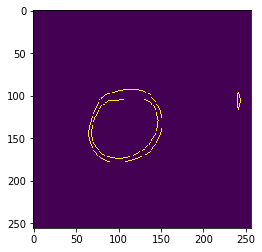

In [58]:
mha = 7
im = imstack[71]
lineindex = 5

imstack = im2arr(files[mha])
frame8 = cv2.convertScaleAbs(im,alpha=(255.0/2.0))   #upscale pixel range to 255
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)   #create rgb version of image
ret, thresh = cv2.threshold(frame8, 129, 255, 0)   #create threshold image
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)   #find contours for both plaque and lumen\

img6 = np.zeros((256,256), np.uint8)
#img6 = im.copy()
#img6 = cv2.convertScaleAbs(img6,alpha=(255.0/2.0))
#img6 = cv2.cvtColor(img6,cv2.COLOR_GRAY2RGB)
cv2.drawContours(img6, contours, -1, (255,0,0), 1)
plt.imshow(img6)
print(hierarchy)

In [180]:
any(np.array(parent) == 0)

False

# TEST Draw half of contour
If you measure the diameters on half of the contour you are still measuring every diameter along the the 360 degrees

102.48902380255166
center 130 157
cpoint1 125 106
cpoint2 126 105
cpoint3 136 207
[[105 126]
 [106 124]
 [106 125]
 [207 134]
 [207 135]
 [207 136]]


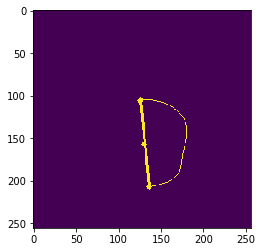

In [18]:
mha = 0
im = imstack[125]
lineindex = 0

imstack = im2arr(files[mha])
frame8 = cv2.convertScaleAbs(im,alpha=(255.0/2.0))   #upscale pixel range to 255
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)   #create rgb version of image
ret, thresh = cv2.threshold(frame8, 129, 255, 0)   #create threshold image
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)   #find contours for both plaque and lumen
parent = [ x[-1] for x in hierarchy[0] ]    #get contour hierarchies
if any(np.array(parent) == 0):
    # only find distance if lumen contour (child) exists
    index = np.where(np.array(parent) == 0)[0][0]   #find child contour (lumen)
    lumen_c = contours[index]   #get lumen contour
    M = cv2.moments(lumen_c)   #get center lumen
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    #points = np.array([lumen_ch[0][0],[cX,cY]])   #get a point on contour
    point = lumen_c[lineindex][0].tolist()
    x0 = point[0]
    y0 = point[1]
    vx = x0-cX
    vy = y0-cY
    #draw line through contour and center
    img5 = np.zeros((256,256), np.uint8)   
    #[vx,vy,x,y] = cv2.fitLine(points, cv2.DIST_L2,0,0.01,0.01)
    l = 300
    cv2.line(img5, (cX-(vx*l), cY-(vy*l)), (cX+(vx*l), cY+(vy*l)), (255,0,0),2)

    #draw contour 
    img3 = np.zeros((256,256,3), np.uint8)
    cv2.drawContours(img3, lumen_c, -1, (255,255,255), 1)
    img4 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    #find intersection of line and contour
    imgcombo = cv2.bitwise_and(img4,img5)
    intersect = np.argwhere(imgcombo == 255)

    x1 = intersect[0][1]
    y1 = intersect[0][0]
    x2 = intersect[-1][1]
    y2 = intersect[-1][0]

    distance = sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    print(distance)

    img6 = np.zeros((256,256), np.uint8)
    cv2.line(img6, (x1, y1), (x2, y2), (255,0,0),2)
    cv2.circle(img6, (round(cX),round(cY)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x0),round(y0)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x1),round(y1)), 3, (255,0,0), -1)
    cv2.circle(img6, (round(x2),round(y2)), 3, (255,0,0), -1)
    #cv2.circle(img6, (0,0), 5, (255,0,0), -1)
    cv2.drawContours(img6, lumen_c[:round(len(lumen_c)/2)], -1, (255,255,255), 1)
    plt.imshow(img6)
    #plt.imshow(img5)

    #plt.imshow(img5 | img4)
    #plt.imshow(imgcombo)
    print("center",cX,cY)
    print("cpoint1",x0,y0)
    print("cpoint2",x1,y1)
    print("cpoint3",x2,y2)
    print(intersect)

# Test find intersection between line and circle

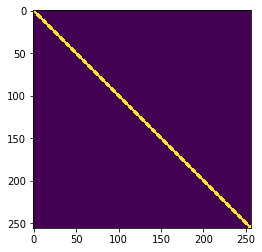

In [306]:
img = np.zeros((256,256), np.uint8)
cv2.line(img,(0,0),(511,511),(255,0,0),2)
plt.imshow(img)

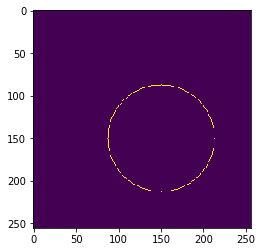

In [307]:
img2 = np.zeros((256,256), np.uint8)
cv2.circle(img2,(150,150), 63, (255,0,0), 1)
plt.imshow(img2)

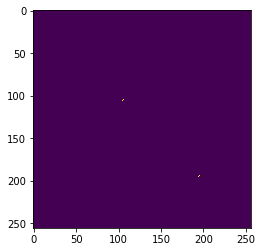

In [308]:
imgcombo = cv2.bitwise_and(img,img2)
plt.imshow(imgcombo)

In [309]:
unique, counts = np.unique(imgcombo, return_counts=True)
>>> dict(zip(unique, counts))

{0: 65532, 255: 4}

In [310]:
intersect = np.argwhere(imgcombo == 255)
intersect

array([[105, 106],
       [106, 105],
       [194, 195],
       [195, 194]])

In [184]:
contX = intersect[0]
contY = intersect[-1]
print(contX, contY)

[105 106] [195 194]


# Test find intersection between line and contour

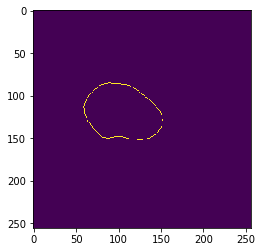

In [217]:
img3 = np.zeros((256,256,3), np.uint8)
cv2.drawContours(img3, lumen_cont, -1, (255,255,255), 1)
img4 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
plt.imshow(img4)

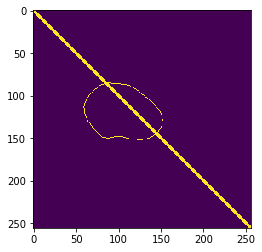

In [225]:
img = np.zeros((256,256), np.uint8)
cv2.line(img,(0,0),(511,511),(255,0,0),2)
plt.imshow(img | img4)

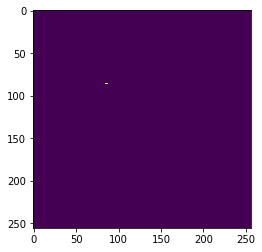

In [220]:
imgcombo = cv2.bitwise_and(img4,img)
plt.imshow(imgcombo)

In [221]:
unique, counts = np.unique(imgcombo, return_counts=True)
>>> dict(zip(unique, counts))

{0: 65530, 255: 6}

In [222]:
intersect = np.argwhere(imgcombo == 255)
intersect

array([[ 86,  84],
       [ 86,  85],
       [ 86,  86],
       [ 86,  87],
       [144, 145],
       [145, 144]])

In [ ]:
lumen_c

In [128]:
#calculate distance between two points pythagorean theorem
#center and 1 point on contour
import time
from math import sqrt
from math import hypot
M = cv2.moments(lumen_c)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
x1 = cX
y1 = cY
x2 = lumen_c[0][0][0]
y2 = lumen_c[0][0][1]
print(sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))

38.01315561749642


In [129]:
lumen_c[0][0]

array([87, 86], dtype=int32)

# Test find child contour the lumen

In [48]:
parent = [ x[-1] for x in hierarchy[0] ]
index = np.where(np.array(parent) == 0)[0][0]
lumen_cont = contours[index]

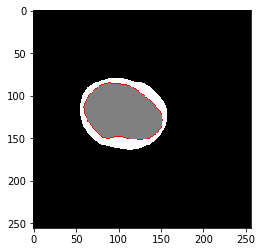

In [214]:
plt.imshow(cv2.drawContours(framergb, lumen_cont, -1, (255,0,0), 1))

In [134]:
cv2.contourArea(lumen_cont)

2922.0

# Test fit an ellipse to lumen contour

In [155]:
(x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_cont)
ellipse = cv2.fitEllipse(lumen_cont)

In [150]:
im3 = framergb.copy()

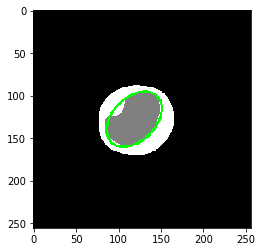

In [152]:
plt.imshow(cv2.ellipse(im3,ellipse,(0,255,0),2))

In [158]:
print(minaxis,maxaxis)

50.585662841796875 76.45760345458984


54.83401107788086 84.93942260742188


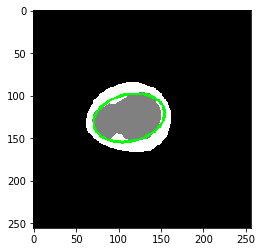

In [215]:
i= 9
frame = im[i]
#plt.imshow(frame)
frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
#plt.imshow(frame8)
ret, thresh = cv2.threshold(frame8, 129, 255, 0)
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
#plt.imshow(framergb)
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
parent = [ x[-1] for x in hierarchy[0] ]
index = np.where(np.array(parent) == 0)[0][0]
lumen_cont = contours[index]
#plt.imshow(cv2.drawContours(framergb, lumen_cont, -1, (255,0,0), 1))
(x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_cont)
ellipse = cv2.fitEllipse(lumen_cont)
im3 = framergb.copy()
plt.imshow(cv2.ellipse(im3,ellipse,(0,255,0),2))
print(minaxis,maxaxis)

In [219]:
def draweclipse(imstack,i):
    frame = imstack[i]
    #plt.imshow(frame)
    frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
    #plt.imshow(frame8)
    ret, thresh = cv2.threshold(frame8, 129, 255, 0)
    framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
    #plt.imshow(framergb)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    parent = [ x[-1] for x in hierarchy[0] ]
    try:
        index = np.where(np.array(parent) == 0)[0][0]
        lumen_cont = contours[index]
        #plt.imshow(cv2.drawContours(framergb, lumen_cont, -1, (255,0,0), 1))
        (x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_cont)
        ellipse = cv2.fitEllipse(lumen_cont)
        im3 = framergb.copy()
        return cv2.ellipse(framergb,ellipse,(0,255,0),2)
    except:
        pass
    

In [207]:
def sample_stack2(stack, rows=5, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        print(start_with,i,show_every,ind)
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(draweclipse(stack,i))
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

In [194]:
imstack.shape

(3970, 256, 256)